In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

income = pd.DataFrame([
    [0,20,0],
    [0,60,2],
    [0,40,1],
    [1,25,1],
    [1,35,2],
    [1,55,1]
    ])
income.columns = ['high_income', 'age', 'marital_status']
income

,high_income,age,marital_status
0,0,20,0
1,0,60,2
2,0,40,1
3,1,25,1
4,1,35,2
5,1,55,1


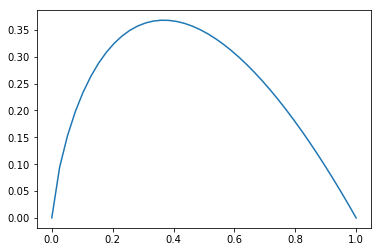

In [14]:
x = np.linspace(0.00001, 1, 40)
y = -x*np.log(x)
plt.plot(x, y)

## Information entropy & information gain

划分选择：

选择最优划分属性，使决策树的分支结点所包含的样本尽可能属于统一类别，即节点的纯度(purity)越来越高．


假定当前样本集合Ｄ中第k类样本所占的比例为$p_k$, 

信息熵(information entropy):

$$Ent(D) = -\sum_{k=1}^{|y|}p_klog_2p_k$$

假设离散属性ａ有Ｖ个可能的取值($a^1, a^2, a^V$).第Ｖ个分支节点包含勒Ｄ中所有在属性ａ上取值为$a^V$的样本，记为$D^V$

信息增益(information gain):

$$Gain(D, a) = Ent(D) - \sum_{v=1}^{V}\frac{D^v}{D}Ent(D^v)$$

In [53]:
def cal_entropy(col_data):
    prob= np.bincount(col_data)/float(len(col_data))
    entropy = 0
    for item in prob:
        if item >0:
            entropy -= item * np.log(item)
    return entropy

entropy_age = cal_entropy(income['age'])
entropy_age

def cal_info_gain(data, split_col, target_col):
    
    original_entropy = cal_entropy(data[target_col])
    
    # split with median
    median = data[split_col].median()
    left_col = data[data[split_col] <= median]
    right_col = data[data[split_col] > median]
#     print 'split_col: ' + str(split_col)
#     print 'median: ' + str(median)
#     print left_col
#     print right_col
    to_subtract = 0
    for col in [left_col, right_col]:
        weight = float(col.shape[0]) / col.shape[0]
        to_subtract -= weight*cal_entropy(col[target_col])
        
    gain = original_entropy + to_subtract
    return gain
    

gains = []
for col in ['age', 'marital_status']:
    gain = cal_info_gain(income, col, 'high_income')
    gains.append(gain)
    
gains

[-0.57988115602968027, -0.69314718055994529]

### Find the best column 

In [34]:
def find_best_col(data, target_col, cols):
    info_gains = []
    for col in cols:
        gain = cal_info_gain(data, col, target_col)
        info_gains.append(gain)
    max_gain = max(info_gains)
    best_col = cols[info_gains.index(max_gain)]
    return best_col

In [36]:
data = pd.DataFrame([
    [0,20,0],
    [0,60,2],
    [0,40,1],
    [1,25,1],
    [1,35,2],
    [1,55,1]
    ])
# Assign column names to the data
data.columns = ["high_income", "age", "marital_status"]

cols = ['age', 'marital_status']

best_col = find_best_col(data, 'high_income', cols)
best_col

'marital_status'

### Put them together 

In [66]:
def id3(data, target_col, cols, tree, nodes):
    
    unique = pd.unique(data[target_col])
    if len(unique) == 1:
        if unique[0] == 0:
            tree['label'] = 0
        elif unique[0] ==1:
            tree['label'] = 1
        #？？？？　why return??
        return 
    nodes.append(len(nodes) + 1)
    tree['number'] = nodes[-1]
    # ???? tree['number']
    
    
    
    best_col = find_best_col(data, target_col, cols)
    median = data[best_col].median()
    tree['column'] = best_col
    tree['number'] = median
    
    left_col = data[data[best_col] < median]
    right_col = data[data[best_col] >= median]
    split_dict = [['left', left_col], ['right', right_col]]
    print tree
    for name, split_col in split_dict:
        tree[name] = {}
        id3(split_col, target_col, cols, tree[name], nodes)

In [67]:
tree ={}
nodes = []

id3(data, 'high_income', ['age', 'marital_status'], tree, nodes)
print 'tree:'
print tree
print 
print 'nodes:'
print nodes

{'column': 'age', 'number': 37.5}
{'column': 'age', 'number': 25.0}
{'column': 'age', 'number': 55.0}
{'column': 'age', 'number': 57.5}
tree:
{'column': 'age', 'right': {'column': 'age', 'right': {'column': 'age', 'right': {'label': 0}, 'number': 57.5, 'left': {'label': 1}}, 'number': 55.0, 'left': {'label': 0}}, 'number': 37.5, 'left': {'column': 'age', 'right': {'label': 1}, 'number': 25.0, 'left': {'label': 0}}}

nodes:
[1, 2, 3, 4]


### Predict single row

In [69]:
def predict(tree, row):
    if 'label' in tree.keys():
        return tree['label']
    column = tree['column']
    median = tree['number']
    
    if row[column] < median:
        return predict(tree['left'], row)
    else:
        return predict(tree['right'], row)
        

In [71]:
row = data.iloc[0]
predict(tree, row)

0

###  Predict batch

In [76]:
def predict_batch(tree, df):
    return df.apply(lambda x: predict(tree, x), axis=1)

predict_batch(tree, data[['age', 'marital_status']])

0    0
1    0
2    0
3    1
4    1
5    1
dtype: int64